In [1]:
#import os, sys
#from time import time
import torch
from torch import Tensor
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
#from torch.cuda.amp import GradScaler, autocast
#from torch.utils.data._utils.collate import default_collate
#import copy
#from time import time
#import wandb
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
from dataset import AEDataset
from trainer import Trainer, WeakSupervisionTrainer
from model import DualBranchAE
from utils import *
from losses import MSELoss
from pretrainer import PreTrainer
from torchmetrics.classification import BinaryROC
from scipy import ndimage
from sklearn.ensemble import IsolationForest

c:\Users\Golo\miniconda3\envs\BA\Lib\site-packages\torch\utils\_contextlib.py:125: UserWarning: Decorating classes is deprecated and will be disabled in future versions. You should only decorate functions or methods. To preserve the current behavior of class decoration, you can directly decorate the `__init__` method and nothing else.
  warnings.warn("Decorating classes is deprecated and will be disabled in "
c:\Users\Golo\miniconda3\envs\BA\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
# auto reload changes in .py files
%load_ext autoreload
%autoreload 2

In [3]:
# %cd example/

# Dataset

We currently work on the HPC data and within this, we built two different segmentation tasks. Further details are in the paper https://cg.cs.uni-bonn.de/backend/v1/files/publications/torayev-vcbm2020.pdf. Neither the whole dataset nor the model are in this repo. We will set you up once you started your work and give your access.

In [4]:
# which tasks are used is handled by "set". 1 is a binary task for debugging, 2 is multi-class 
# and so is 3 but with asymmetric classes w.r.t. the saggital plane (harder). Details for 
# set 2 and 3 are in the paper.
# 'modality' handles the target provided by __getitem__. Options are reconstruction and segmentation.
# When segmentation is selected, the labels are taken from the annotations attribute. This is also where
# the user-model interacts with the dataset. Ground truth masks are in the label attribute. All other parameters are
# from past experiments and alter the behaviour. This project has been around for a while, so some are not used anymore.

# normalize is usually set to true. Simply normalizes the input. Augment is legacy, we didn't have much success
# with data augmentation. balance takes care of data balancing during a batch. Some classes are under-
# represented so we show them to the model more often. It helps quite a bit during training so consider 
# integrating it. We can talk about how this is done in detail once you start. init defines how the user-model behaves. 
# We considered different behaviours w.r.t. to annotation style and quantity and such. 
# To_gpu moves ALL data to GPU. Since we only work on a single volume (i.e. couple hundred slices) 
# we move everything to GPU and avoid latency in dataloading. Takes a hefty chunk out of the VRAM though 
# but makes things faster.

# Feel free to re-write anything you want. This is partly dated code that could use a re-write anyways.

# Example:
# make a config first. This handles globals and is used through-out the script. Many things that were tried in
# experiments later have not yet made it into the config, but most have.

cfg = {
    # CONFIG
    'name': 'location-unsupervised',
    'project': 'IDVR-localization_pretrain',
    'log': False,
    'rank': 0,
    
    # DATA
    'data_dir': '../../../data/784565/Diffusion/',
    'data_path': '../../../data/784565/Diffusion/data.nii',
    'active_mask_path': '../../../data/784565/Diffusion/nodif_brain_mask.nii.gz',
    
    # SELF SUPERVISED PRE-TRAINING
    's_n_epochs': 20,
    's_batch_size': 16, # default: 8
    's_lr': 5e-4, #1e-4, 1e-5        
    
    # TRAINING WITH WEAK SUPERVISION
    'p_n_epochs': 100,
    'w_n_epochs': 10,
    'w_batch_size': 2,
    'w_lr': 5e-4,    #5e-5 
    'w_eval_freq': 100,
    
    # RANDOM FOREST
    'min_samples_leaf': 8,
    
    # USER MODEL
    'init_voxels': 200,
    'refinement_voxels': 200,
    'num_interactions': 10,
}

In [5]:
# we set balance to true. This also effects the dataloader later
balance = False
dataset = AEDataset(cfg, modality='segmentation', normalize=True,
                    set=2, augment=False, balance=balance, init='per_class', to_gpu=False)

# currently, there are no annotations. We can also enforce this with clear_annotations() at any point
dataset.clear_annotation()
# get initial annotations
annot = dataset.initial_annotation(seed=42)
# and update the dataset
dataset.update_annotation(annot)
print(f"number of annotations: {dataset.annotations.detach().cpu().sum()}")

# The dataset currently always provides 4 items. Input (the image), target (the input for reconstruction or 
# the annotations for segmentation), weights that mask out voxels which are not annotated for segmentation 
# and a brain mask for masking background during reconstruction
item = dataset[0]
print(item.keys())

number of annotations: 9510.0
dict_keys(['input', 'target', 'weight', 'mask'])


In [6]:
print(len(dataset))

145


In [7]:
print(item['input'].shape)
print(item['target'].shape)
print(item['weight'].shape)
print(item['mask'].shape)

torch.Size([288, 145, 145])
torch.Size([5, 145, 145])
torch.Size([1, 145, 145])
torch.Size([145, 145])


# Model and Inference

The overall pipeline is illustrated in the README.

In [8]:
# At first, we do not have annotations but still need features for the Random Forest. So we pre-train 
# on a reconstruction task and later re-use the same Encoder (the part of the network that outputs our features),
# simply replace the decoder and resume training. 

# init the model with segmentation decoder. Have a look at the source code for additional guidance. The dataset
# updates the config to contain labels. We initialize with one channel per class.
model = DualBranchAE(encoder    = 'dual',
                     decoder    = 'segmentation',
                     in_size    = 145,
                     n_classes  = len(cfg['labels']),
                     thresholds = 'learned') #.to(cfg['rank'])

# example model from one of the experiments
#model_path = 'example_dual_xy_0_best.pt'
model_path = 'models/Test_best.pt'

# load the components
checkpoint           = torch.load(model_path)
model_state_dict     = checkpoint['model_dict']
encoder_state_dict   = {k.replace('encoder.', ''): v for k, v in model_state_dict.items() if 'encoder' in k}

# copy encoder weights to model. Decoder weights remain as they are, initialized as random
model.encoder.load_state_dict(encoder_state_dict, strict=True)

# Define the dataloader. If we use balanced sampling in the dataset, we also need the custom balanced_collate 
# function in the dataloader. This handles the unusal batching logic.

if balance:
    loader  = DataLoader(dataset, 
                         batch_size=cfg['w_batch_size'], 
                         shuffle=True, 
                         drop_last=False, 
                         collate_fn=balanced_collate)
else:
    loader  = DataLoader(dataset, 
                         batch_size=16, 
                         shuffle=True, 
                         drop_last=False)

In [9]:
# For evaluation, we are interested in the Random Forest (RF) prediction based on
# the CNN features. 

# write checkpoints for stuff that changes the behaviour of the dataset.
# E.g. balancing changes the __getitem__ method and thus influences 
# evaluation. Turn it off and on later if needed.
augment_checkpoint = dataset.augment
balance_checkpoint = dataset.balance
dataset.augment = False
dataset.balance = False

# define the layer you want the features from. This is usually the encoder output.
f_layer = 'encoder'
# Init the feature extractor. Have a look at PyTorchs Hook functionality.
extractor = FeatureExtractor(model, layers=[f_layer])
# Cache all features for a dataset and reformat/move to numpy for random forest stuff
hooked_results  = extractor(dataset)
features = hooked_results[f_layer]
features  = features.permute(0,2,3,1).numpy()
# In the utils file are a bunch of evaluation scripts, some are not used anymore.
# This one provides F1 scores for the whole dataset based on all ground truth labels
# and also the predictions themselve as given by the RF. We need them later to update the annotations with
# the user model.
scores, rf_prediction = evaluate_RF(dataset, features, cfg)
print(f"Average F1 score for RF after initial user interaction:    {scores['Avg_f1_tracts'].item():.4f}")
# Turn dataset attributes to normal again
dataset.augment = augment_checkpoint
dataset.balance = balance_checkpoint

 #we can use the predictions to update the annotations via the user model
annot = dataset.refinement_annotation(prediction=rf_prediction, seed=42)
dataset.update_annotation(annot)
scores, rf_prediction = evaluate_RF(dataset, features, cfg)
print(f"Average F1 score for RF after additional user interaction: {scores['Avg_f1_tracts'].item():.4f}")
 #Now you can change the model and features to your liking and try again (e.g. via constrastive learning ;)).
 #The scores from the RF are the signal you need for evaluation, the rest is up to you.

Average F1 score for RF after initial user interaction:    0.3152
Average F1 score for RF after additional user interaction: 0.3604


In [10]:
print(f"number of annotations: {dataset.annotations.detach().cpu().sum()}")

number of annotations: 16194.0


# Was passiert in Evaluate RF?

In [11]:
train_mask  = dataset.weight.detach().cpu().squeeze().numpy()    #.permute(0,2,3,1).repeat(1,1,1,44).numpy()
test_mask   = dataset.brain_mask.detach().cpu().numpy()#.unsqueeze(3).repeat(1,1,1,44).numpy()
train_label = dataset.annotations.detach().cpu().permute(1,2,3,0).numpy()
test_label  = dataset.label.detach().cpu().permute(1,2,3,0).numpy()

print(train_mask.shape)
print(test_mask.shape)
print(train_label.shape)
print(test_label.shape)

(145, 145, 145)
(145, 145, 145)
(145, 145, 145, 5)
(145, 145, 145, 5)


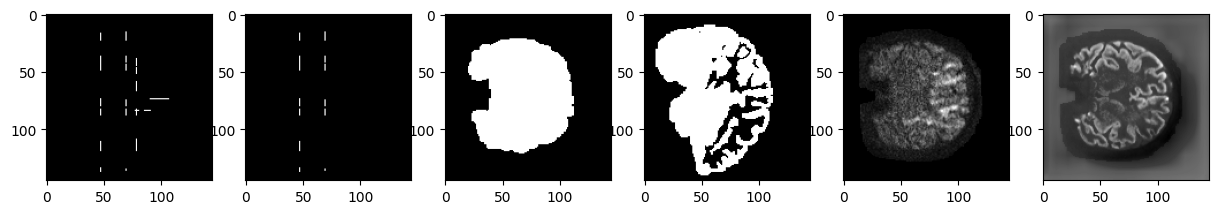

In [12]:
n = 97
fix, axs = plt.subplots(1,6, figsize=(15,20))
axs = axs.flatten()
axs[0].imshow(train_mask[n,:,:], cmap='gray')
axs[1].imshow(dataset.annotations[0,n,:,:], cmap='gray')
axs[2].imshow(dataset.brain_mask[n,:,:], cmap='gray')
axs[3].imshow(dataset.label[0,n,:,:], cmap='gray')
axs[4].imshow(dataset.input[n, 150,:,:], cmap='gray')
axs[5].imshow(features[n,:,:, 4], cmap='gray')
plt.show()

In [13]:
# Input - Mask voxels that are not labelled before flattening the input
X_train = features.reshape((-1, features.shape[-1]))[train_mask.reshape(-1) == 1]
X_test  = features.reshape((-1, features.shape[-1]))[test_mask.reshape(-1)  == 1]
# Target - Same as above. Mask before flattening
Y_train = train_label.reshape((-1, train_label.shape[-1]))[train_mask.reshape(-1) == 1]
Y_test  = test_label.reshape((-1,  train_label.shape[-1]))[test_mask.reshape(-1)  == 1]

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(15861, 44)
(844350, 44)
(15861, 5)
(844350, 5)


In [14]:
# Init Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100,
                     bootstrap=True,
                     oob_score=True,
                     random_state=0,
                     n_jobs=-1,
                     max_features="sqrt", # changed from "auto" because auto got removed
                     class_weight="balanced",
                     max_depth=None,
                     min_samples_leaf=cfg["min_samples_leaf"])

In [15]:
# Train
clf.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=8, n_jobs=-1,
                       oob_score=True, random_state=0)

In [16]:
# predict labels in test mask
predicted_prob    = clf.predict_proba(X_test) # Liste mit 5 Einträgen a 844350 Elementen
Y_predicted_prob  = torch.tensor(np.array([p[:, 1] for p in predicted_prob])).T # 844350 x 5
Y_predicted_label = (Y_predicted_prob > 0.5)*1

In [17]:
n_classes = len(cfg['labels'])
prediction = torch.zeros((145,145,145, n_classes))
prediction.view(-1, n_classes)[test_mask.reshape(-1)  == 1] = Y_predicted_label.float()

## Unsicherheit mittels Entropy 

### Entropy einmal pro Klasse berechnen und dann mitteln

In [18]:
eps = 1e-5

def calc_binary_entropy(prob):
    
    #Edge Cases
    prob = torch.clamp(prob, eps, 1-eps)
    
    return -(prob*torch.log2(prob) + (1-prob)*torch.log2(1-prob))

In [19]:
entropy = calc_binary_entropy(Y_predicted_prob)
mean_entropy = entropy.mean(axis=-1)

In [20]:
entropy_map = torch.zeros((145,145,145))
entropy_map[test_mask  == 1] = mean_entropy.float()

### Binäre Maske überall 1 wo prediction != ground truth. Target für Klassifikation, wobei Unsicherheit = Prediction.

In [21]:
error_map = torch.where(prediction - test_label != 0, 1, 0)
error_map = torch.any(error_map, dim=-1) * 1

### ROC (Unsicherheit normalisieren, binäre Fehlermaske)

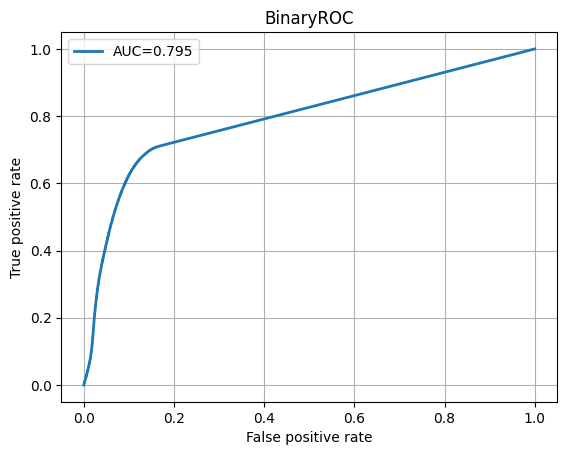

In [22]:
def calc_ROC(uncertainty_map, err_map) -> None:

    # scale and normalize uncertainty_map to [0,1]
    min_value = uncertainty_map.min()
    max_value = uncertainty_map.max()
    map_normalized = (uncertainty_map - min_value) / (max_value - min_value)

    # calculate ROC
    metric = BinaryROC()
    metric.update(map_normalized, err_map)
    fig_, ax_ = metric.plot(score=True)

calc_ROC(entropy_map, error_map)

## Unsicherheit mittels Räumlicher Distanz (Euklidische Distanz)

Schritte:
1. Bild einteilen in markierte und nicht markierte Voxel
2. Räumliche Distanz jedes nicht markierten Voxels zum nächsten markierten Voxel
3. ROC ausrechnen

In [23]:
# Schritt 1
annotated_mask = torch.any(dataset.annotations, dim=0)
not_annotated_mask = torch.logical_not(annotated_mask)

In [24]:
# Schritt 2
spatial_distances = torch.tensor(ndimage.distance_transform_edt(not_annotated_mask))

spatial_distance_map = torch.zeros((145,145,145))
spatial_distance_map[test_mask  == 1] = spatial_distances[test_mask == 1].float()

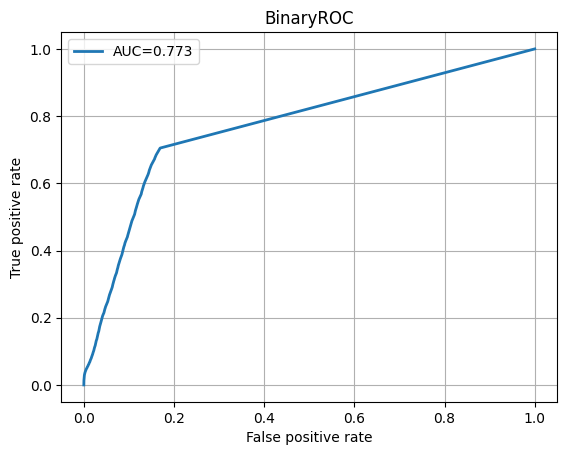

In [25]:
# Schritt 3
calc_ROC(spatial_distance_map, error_map)

## Unsicherheit mittels Feature Distanz (Euklidische Distanz)
MSE wird durch anomaly score eines isolation forests ersetzt. 

Schritte:
1. Isolation Forest auf gelabelten Daten fitten
1. Anomaly Score für Voxel ausrechnen die zum Gehirn (test_mask) gehören und nicht annotiert (not_annotated_mask) sind
3. Anomaly Score liegt in [-0.5, 0.5], wobei $< 0$ outlier und $>0$ inliner (scikit-Implementation). $\Rightarrow$ In Bereich [0, 1] bringen, wobei nahe 0 inliner und nahe 1 outlier sein soll.
4. ROC ausrechnen

In [92]:
# Schritt 1
annotated_features = features[annotated_mask].reshape(-1, 44)

iforest = IsolationForest(n_estimators=100, 
                        random_state=0,
                        n_jobs=-1)
iforest.fit(annotated_features)

IsolationForest(n_jobs=-1, random_state=0)

In [94]:
# Schritt 2
brain_na_mask = (torch.from_numpy(test_mask == 1)) & (not_annotated_mask == 1)

anomaly_scores = iforest.decision_function(features[brain_na_mask].reshape(-1, 44))
# Schritt 3
anomaly_scores = 1 - (anomaly_scores + 0.5) # in Bereich [0,1] verschieben und dann dafür sorgen, dass nahe 0 inliner und nahe 1 outlier ist.

In [96]:
# Schritt 4
anomaly_scores_map = torch.zeros((145,145,145))
anomaly_scores_map[brain_na_mask] = torch.from_numpy(anomaly_scores).float()

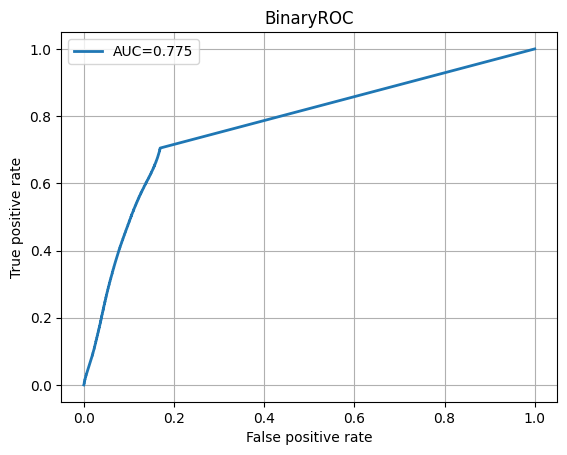

In [97]:
calc_ROC(anomaly_scores_map, error_map)

# Pretraining without labels

Before we have any annotations, we pretrain with a reconstruction task that also tries to infer the location of voxels as additional signal. 



In [4]:
# number of out going channales depends on whether we also want to localize voxels in 
# the XY plane. If yes, its 290 and 288 o/w.
localize = True
out_channel = 290 if localize else 288
model = DualBranchAE(encoder='dual',
                     decoder='reconstruction',
                     in_size=145,
                     recon_channel=out_channel)

# for the dataset only the localization is interesting. We always normalize
# and select a set / whether we want to use a GPU
dataset = AEDataset(cfg, modality='reconstruction', normalize=True,
                    set=2, augment=False, localize=localize, to_gpu=False)
dataset.clear_annotation()
annot = dataset.initial_annotation(seed=42)
dataset.update_annotation(annot)

# define a criterion for the reconstruction task. This is simply a MSE loss
criterion = MSELoss()
loader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=False)
# give it a name and see whether you want to log anything with WandB
description = 'Test' 
log = False

# init the trainer and you are good to go
pre_trainer = PreTrainer(model, criterion, loader, cfg, n_epochs=cfg['s_n_epochs'], 
                         lr=cfg['s_lr'], log=log, description=description,
                         patience=8, es_mode='none', device='cpu')

In [5]:
pre_trainer.fit()

  0%|          | 0/20 [00:00<?, ?it/s]

# Weakly Supervised Training with Segmentation Head

Once you have implemented your pipeline we can compare to what we currently do. Since its in active development and changes alot currently, we will go over it once you are there.